In [1]:
%matplotlib inline

import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.5)

Applications of Linear Alebra: PCA
====

We will explore 3 applications of linear algebra in data analysis - change of basis (for dimension reduction), projections (for solving linear systems) and the quadratic form (for optimization). The first application is the change of basis to the eigenvector basis that underlies Principal Components Analysis s(PCA).

We will review the following in class:

- The standard basis
- Orthonormal basis and orthgonal matrices
- Change of basis
- Similar matrices
- Eigendecomposition
- Sample covariance
- Covariance as a linear transform
- PCA and dimension reduction
- PCA and "explained variance"
- SVD

Variance and covariance
----

Remember the formula for covariance

$$
\text{Cov}(X, Y) = \frac{\sum_{i=1}^n(X_i - \bar{X})(Y_i - \bar{Y})}{n-1}
$$

where $\text{Cov}(X, X)$ is the sample variance of $X$.

In [2]:
def cov(x, y):
    """Returns covariance of vectors x and y)."""
    xbar = x.mean()
    ybar = y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

In [3]:
X = np.random.random(10)
Y = np.random.random(10)

In [4]:
np.array([[cov(X, X), cov(X, Y)], [cov(Y, X), cov(Y,Y)]])

array([[ 0.0495287 , -0.00474943],
       [-0.00474943,  0.10057312]])

In [5]:
# This can of course be calculated using numpy's built in cov() function
np.cov(X, Y)

array([[ 0.0495287 , -0.00474943],
       [-0.00474943,  0.10057312]])

In [6]:
# Extension to more variables is done in a pair-wise way
Z = np.random.random(10)
np.cov([X, Y, Z])

array([[ 0.0495287 , -0.00474943, -0.00618675],
       [-0.00474943,  0.10057312, -0.01860316],
       [-0.00618675, -0.01860316,  0.05552326]])

Eigendecomposition of the covariance matrix
----

In [7]:
mu = [0,0]
sigma = [[0.6,0.2],[0.2,0.2]]
n = 1000
x = np.random.multivariate_normal(mu, sigma, n).T

In [8]:
A = np.cov(x)

In [9]:
m = np.array([[1,2,3],[6,5,4]])
ms = m - m.mean(1).reshape(2,1)
np.dot(ms, ms.T)/2

array([[ 1., -1.],
       [-1.,  1.]])

In [10]:
e, v = np.linalg.eig(A)

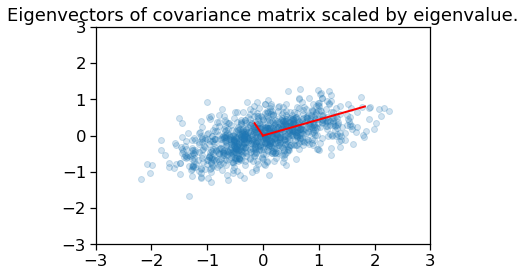

In [11]:
plt.scatter(x[0,:], x[1,:], alpha=0.2)
for e_, v_ in zip(e, v.T):
    plt.plot([0, 3*e_*v_[0]], [0, 3*e_*v_[1]], 'r-', lw=2)
plt.axis([-3,3,-3,3])
plt.title('Eigenvectors of covariance matrix scaled by eigenvalue.');

Covariance matrix as a linear transformation
----

The covariance matrix is a linear transformation that maps $\mathbb{R}^n$ in the direction of its eigenvectors with scaling factor given by the eigenvalues. Here we see it applied to a collection of random vectors in the box bounded by [-1, 1].

### We will assume we have a covariance matrix

In [12]:
covx = np.array([[1,0.6],[0.6,1]])

### Create random vectors in a box

In [13]:
u = np.random.uniform(-1, 1, (100, 2)).T

### Apply covariance matrix as linear transformation

In [14]:
y = covx @ u

In [15]:
e1, v1 = np.linalg.eig(covx)

### The linear transform maps the random vectors as described.

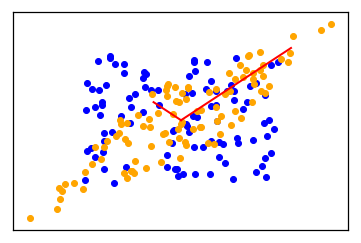

In [16]:
plt.scatter(u[0], u[1], c='blue')
plt.scatter(y[0], y[1], c='orange')
for e_, v_ in zip(e1, v1.T):
    plt.plot([0, e_*v_[0]], [0, e_*v_[1]], 'r-', lw=2)
plt.xticks([])
plt.yticks([])
pass

PCA
----

Principal Components Analysis (PCA) basically means to find and rank all the eigenvalues and eigenvectors of a covariance matrix. This is useful because high-dimensional data (with $p$ features) may have nearly all their variation in a small number of dimensions $k$, i.e. in the subspace spanned by the eigenvectors of the covariance matrix that have the $k$ largest eigenvalues. If we project the original data into this subspace, we can have a dimension reduction (from $p$ to $k$) with hopefully little loss of information.

Numerically, PCA is typically done using SVD on the data matrix rather than eigendecomposition on the covariance matrix. The next section explains why this works.

### Data matrices that have zero mean for all feature vectors

\begin{align}
\text{Cov}(X, Y) &= \frac{\sum_{i=1}^n(X_i - \bar{X})(Y_i - \bar{Y})}{n-1} \\
  &= \frac{\sum_{i=1}^nX_iY_i}{n-1} \\
  &= \frac{XY^T}{n-1}
\end{align}

and so the covariance matrix for a data set X that has zero mean in each feature vector is just $XX^T/(n-1)$. 

In other words, we can also get the eigendecomposition of the covariance matrix from the positive semi-definite matrix $XX^T$.

### Note that zeroing the feature vector does not affect the covariance matrix

In [17]:
np.set_printoptions(precision=3)

In [18]:
X = np.random.random((5,4))
X

array([[0.855, 0.667, 0.536, 0.461],
       [0.146, 0.353, 0.268, 0.189],
       [0.824, 0.852, 0.85 , 0.165],
       [0.246, 0.469, 0.454, 0.218],
       [0.423, 0.35 , 0.367, 0.064]])

In [19]:
### Subtract the row mean from each row

In [20]:
Y = X - X.mean(1)[:, None]

In [21]:
Y.mean(1)

array([ 0.000e+00,  0.000e+00, -2.776e-17,  2.776e-17,  0.000e+00])

In [22]:
Y

array([[ 0.225,  0.037, -0.094, -0.169],
       [-0.093,  0.114,  0.029, -0.05 ],
       [ 0.151,  0.179,  0.177, -0.508],
       [-0.101,  0.122,  0.107, -0.129],
       [ 0.122,  0.049,  0.066, -0.237]])

In [23]:
### Calculate the covariance

In [24]:
np.cov(X)

array([[ 0.03 , -0.004,  0.037, -0.002,  0.021],
       [-0.004,  0.008,  0.012,  0.011,  0.003],
       [ 0.037,  0.012,  0.115,  0.03 ,  0.053],
       [-0.002,  0.011,  0.03 ,  0.018,  0.01 ],
       [ 0.021,  0.003,  0.053,  0.01 ,  0.026]])

In [25]:
np.cov(Y)

array([[ 0.03 , -0.004,  0.037, -0.002,  0.021],
       [-0.004,  0.008,  0.012,  0.011,  0.003],
       [ 0.037,  0.012,  0.115,  0.03 ,  0.053],
       [-0.002,  0.011,  0.03 ,  0.018,  0.01 ],
       [ 0.021,  0.003,  0.053,  0.01 ,  0.026]])

Eigendecomposition of the covariance matrix
----

In [26]:
e1, v1 = np.linalg.eig(np.dot(x, x.T)/(n-1))

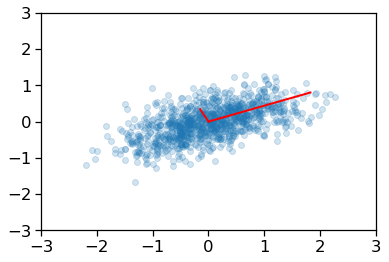

In [27]:
plt.scatter(x[0,:], x[1,:], alpha=0.2)
for e_, v_ in zip(e1, v1.T):
    plt.plot([0, 3*e_*v_[0]], [0, 3*e_*v_[1]], 'r-', lw=2)
plt.axis([-3,3,-3,3]);

Change of basis via PCA
----

### We can transform the original data set so that the eigenvectors are the basis vectors and find the new coordinates of the data points with respect to this new basis

This is the change of basis transformation covered in the Linear Alegebra module. First, note that the covariance matrix is a real symmetric matrix, and so the eigenvector matrix is an orthogonal matrix. 

In [28]:
e, v = np.linalg.eig(np.cov(x))
v.dot(v.T)

array([[1., 0.],
       [0., 1.]])

### Linear algebra review for change of basis

Graphical illustration of change of basis
----

![Commuative diagram](figs/spectral.png)

Suppose we have a vector $u$ in the standard basis $B$ , and a matrix $A$ that maps $u$ to $v$, also in $B$. We can use the eigenvalues of $A$ to form a new basis $B'$. As explained above, to bring a vector $u$ from $B$-space to a vector $u'$ in $B'$-space, we multiply it by $Q^{-1}$, the inverse of the matrix having the eigenvctors as column vectors. Now, in the eigenvector basis, the equivalent operation to $A$ is the diagonal matrix $\Lambda$ - this takes $u'$ to $v'$. Finally, we convert $v'$ back to a vector $v$ in the standard basis by multiplying with $Q$.

In [29]:
ys = np.dot(v1.T, x)

#### Principal components

Principal components are simply the eigenvectors of the covariance matrix used as basis vectors. Each of the original data points is expressed as a linear combination of the principal components, giving rise to a new set of coordinates. 

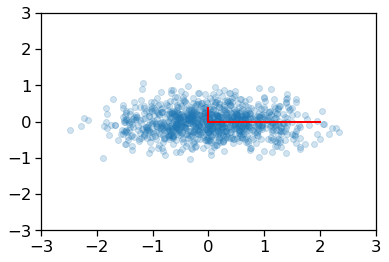

In [30]:
plt.scatter(ys[0,:], ys[1,:], alpha=0.2)
for e_, v_ in zip(e1, np.eye(2)):
    plt.plot([0, 3*e_*v_[0]], [0, 3*e_*v_[1]], 'r-', lw=2)
plt.axis([-3,3,-3,3]);

For example, if we only use the first column of `ys`, we will have the projection of the data onto the first principal component, capturing the majority of the variance in the data with a single feature that is a linear combination of the original features.

#### Transform back to original coordinates

We may need to transform the (reduced) data set to the original feature coordinates for interpretation. This is simply another linear transform (matrix multiplication).

In [31]:
zs = np.dot(v1, ys)

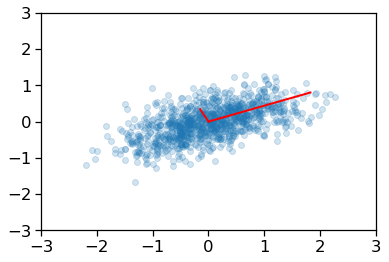

In [32]:
plt.scatter(zs[0,:], zs[1,:], alpha=0.2)
for e_, v_ in zip(e1, v1.T):
    plt.plot([0, 3*e_*v_[0]], [0, 3*e_*v_[1]], 'r-', lw=2)
plt.axis([-3,3,-3,3]);

In [33]:
u, s, v = np.linalg.svd(x)
u.dot(u.T)

array([[1.00e+00, 1.11e-16],
       [1.11e-16, 1.00e+00]])

Dimension reduction via PCA
----

We have the sepctral decomposition of the covariance matrix

$$
A = Q^{-1}\Lambda Q
$$

Suppose $\Lambda$ is a rank $p$ matrix. To reduce the dimensionality to $k \le p$, we simply set all but the first $k$ values of the diagonal of $\Lambda$ to zero. This is equivalent to ignoring all except the first $k$ principal components.

What does this achieve? Recall that $A$ is a covariance matrix, and the trace of the matrix is the overall variability, since it is the sum of the variances.

In [34]:
A

array([[0.578, 0.199],
       [0.199, 0.212]])

In [35]:
A.trace()

0.7895579305747163

In [36]:
e, v = np.linalg.eig(A)
D = np.diag(e)
D

array([[0.665, 0.   ],
       [0.   , 0.124]])

In [37]:
D.trace()

0.7895579305747163

In [38]:
D[0,0]/D.trace()

0.8424777390334711

Since the trace is invariant under change of basis, the total variability is also unchanged by PCA. By keeping only the first $k$ principal components, we can still "explain" $\sum_{i=1}^k e[i]/\sum{e}$ of the total variability. Sometimes, the degree of dimension reduction is specified as keeping enough principal components so that (say) $90\%$ of the total variability is explained.

### Using Singular Value Decomposition (SVD) for PCA

SVD is a decomposition of the data matrix $X = U S V^T$ where $U$ and $V$ are orthogonal matrices and $S$ is a diagnonal matrix. 

Recall that the transpose of an orthogonal matrix is also its inverse, so if we multiply on the right by $X^T$, we get the follwoing simplification

\begin{align}
X &= U S V^T \\
X X^T &= U S V^T (U S V^T)^T \\
 &= U S V^T V S U^T \\
 &= U S^2 U^T
\end{align}

Compare with the eigendecomposition of a matrix $A = W \Lambda W^{-1}$, we see that SVD gives us the eigendecomposition of the matrix $XX^T$, which as we have just seen, is basically a scaled version of the covariance for a data matrix with zero mean, with the eigenvectors given by $U$ and eigenvealuse by $S^2$ (scaled by $n-1$)..


In [39]:
u, s, v = np.linalg.svd(x)

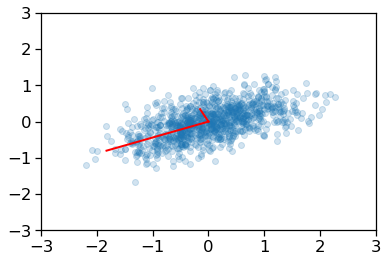

In [40]:
e2 = s**2/(n-1)
v2 = u
plt.scatter(x[0,:], x[1,:], alpha=0.2)
for e_, v_ in zip(e2, v2):
    plt.plot([0, 3*e_*v_[0]], [0, 3*e_*v_[1]], 'r-', lw=2)
plt.axis([-3,3,-3,3]);

In [41]:
v1 # from eigenvectors of covariance matrix

array([[ 0.916, -0.402],
       [ 0.402,  0.916]])

In [42]:
v2 # from SVD

array([[-0.916, -0.402],
       [-0.402,  0.916]])

In [43]:
e1 # from eigenvalues of covariance matrix

array([0.665, 0.125])

In [44]:
e2 # from SVD

array([0.665, 0.125])

In [45]:
a0 = np.random.normal(0,1,100)
a1 = a0 + np.random.normal(0,3,100)
a2 = 2*a0 + a1 + np.random.normal(5,0.01,100)
xs = np.vstack([a0, a1, a2])
xs.shape

(3, 100)

In [46]:
C = np.cov(xs)

In [47]:
C

array([[ 1.069,  1.632,  3.77 ],
       [ 1.632, 10.081, 13.345],
       [ 3.77 , 13.345, 20.884]])

In [48]:
e, v = np.linalg.eig(C)

In [49]:
v

array([[-0.136, -0.816,  0.561],
       [-0.551, -0.408, -0.728],
       [-0.823,  0.408,  0.394]])

In [50]:
U, s, V = np.linalg.svd(xs)

In [51]:
(s**2)/(99)

array([51.845,  5.777,  0.684])

In [52]:
U

array([[-0.085,  0.062,  0.994],
       [-0.307,  0.948, -0.086],
       [-0.948, -0.313, -0.061]])

In [53]:
np.round(e/e.sum(), 4)

array([0.95, 0.  , 0.05])

In [54]:
ys = np.linalg.inv(v).dot(xs)

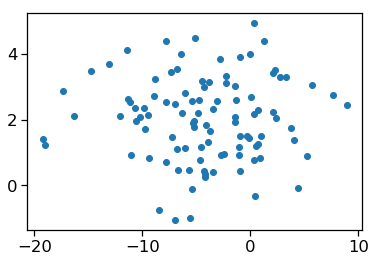

In [55]:
plt.scatter(ys[0,:], ys[2,:])
pass

In [56]:
zs = v[:, [0,2]].dot(ys[[0,2],:])
zs.shape

(3, 100)

In [57]:
v[:, [0,2]]

array([[-0.136,  0.561],
       [-0.551, -0.728],
       [-0.823,  0.394]])

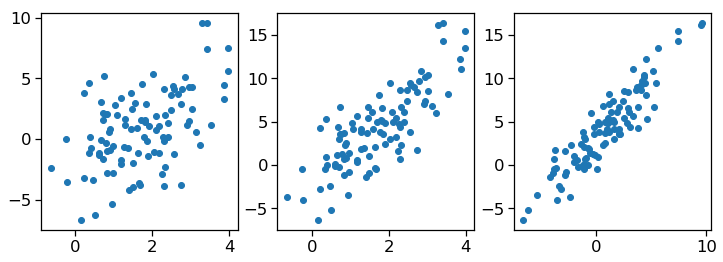

In [58]:
plt.figure(figsize=(12.,4))
plt.subplot(1,3,1)
plt.scatter(zs[0,:], zs[1,:])
plt.subplot(1,3,2)
plt.scatter(zs[0,:], zs[2,:])
plt.subplot(1,3,3)
plt.scatter(zs[1,:], zs[2,:])
pass

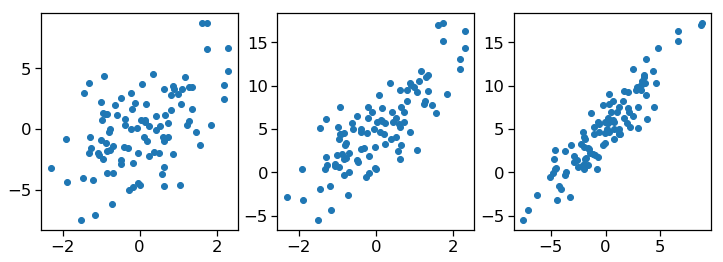

In [59]:
plt.figure(figsize=(12.,4))
plt.subplot(1,3,1)
plt.scatter(xs[0,:], xs[1,:])
plt.subplot(1,3,2)
plt.scatter(xs[0,:], xs[2,:])
plt.subplot(1,3,3)
plt.scatter(xs[1,:], xs[2,:])
pass

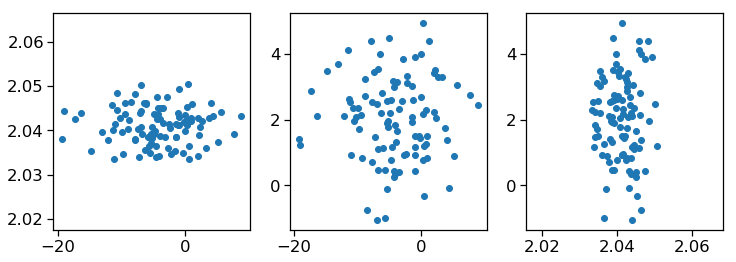

In [60]:
plt.figure(figsize=(12.,4))
plt.subplot(1,3,1)
plt.scatter(ys[0,:], ys[1,:])
plt.subplot(1,3,2)
plt.scatter(ys[0,:], ys[2,:])
plt.subplot(1,3,3)
plt.scatter(ys[1,:], ys[2,:])
pass